# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### embedを得るためのnote

In [ ]:
! nvidia-smi

Wed May 25 07:01:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=500
    epochs=4
    encoder_lr=1e-5
    decoder_lr=1e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True

    name = "exp015" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [ ]:
COLAB = "google.colab" in sys.modules

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 1.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=2210bdc3d62ab9617b7730241fb5f683c3c716b971533c0a2d7e07fe9f41002e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 9.7 MB/s 
     |████████████████████████████████| 596 kB 13.2 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 52.7 MB/s 
     |████████████████████████████████| 1.2 MB 47.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

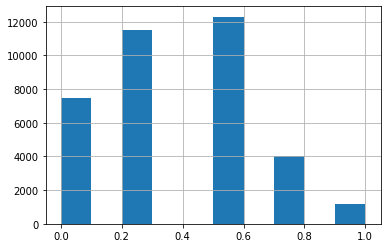

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'], train['anchor'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7334
1    6945
2    7271
3    7399
4    7524
dtype: int64

In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [ ]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()
        # in_features は各トークンに対するベクトルの次元数
        # max_length は最大トークン数
        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        in_features = self.config.hidden_size
        self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
#         print(feature.shape)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 2**8-1, #63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'max_depth': 8,
#     'min_data_in_leaf': 50,   # default = 20
    'verbosity': -1,
}
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=10)

    return bst, embeds, targets

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            _, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())

        y_preds = gbdt.predict(embed.to('cpu').numpy())
        preds.append(y_preds)

    predictions = np.concatenate(preds)
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
#     predictions = np.concatenate(predictions)
    return predictions, embeds, targets


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt, embeds_tr, targets_tr = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions, embeds_va, targets_va = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")
        
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_tr", embeds_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_tr", targets_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_va", embeds_va)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_va", targets_va)

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1821] Elapsed 0m 2s (remain 70m 16s) Loss: 0.6701(0.6701) Grad: 90247.5781  LR: 0.00000002  
Epoch: [1][100/1821] Elapsed 1m 38s (remain 28m 2s) Loss: 0.6303(0.6659) Grad: 101790.7656  LR: 0.00000202  
Epoch: [1][200/1821] Elapsed 3m 15s (remain 26m 13s) Loss: 0.6099(0.6632) Grad: 133855.2500  LR: 0.00000402  
Epoch: [1][300/1821] Elapsed 4m 51s (remain 24m 32s) Loss: 0.6026(0.6607) Grad: 89700.5938  LR: 0.00000602  
Epoch: [1][400/1821] Elapsed 6m 28s (remain 22m 54s) Loss: 0.6574(0.6602) Grad: 52361.0352  LR: 0.00000802  
Epoch: [1][500/1821] Elapsed 8m 4s (remain 21m 16s) Loss: 0.5939(0.6581) Grad: 110699.7969  LR: 0.00001000  
Epoch: [1][600/1821] Elapsed 9m 41s (remain 19m 39s) Loss: 0.6334(0.6540) Grad: 87347.8438  LR: 0.00000999  
Epoch: [1][700/1821] Elapsed 11m 17s (remain 18m 2s) Loss: 0.6434(0.6490) Grad: 46597.0039  LR: 0.00000998  
Epoch: [1][800/1821] Elapsed 12m 53s (remain 16m 25s) Loss: 0.6194(0.6427) Grad: 54763.9844  LR: 0.00000995  
Epoch: [1][900/1821]

Epoch 1 - Score: 0.8141


Epoch: [2][0/1821] Elapsed 0m 1s (remain 36m 49s) Loss: 0.5244(0.5244) Grad: 61520.0078  LR: 0.00000909  
Epoch: [2][100/1821] Elapsed 1m 37s (remain 27m 42s) Loss: 0.4952(0.5303) Grad: 64737.0742  LR: 0.00000895  
Epoch: [2][200/1821] Elapsed 3m 14s (remain 26m 3s) Loss: 0.3577(0.5325) Grad: 132630.7500  LR: 0.00000881  
Epoch: [2][300/1821] Elapsed 4m 50s (remain 24m 25s) Loss: 0.6337(0.5338) Grad: 45012.6133  LR: 0.00000865  
Epoch: [2][400/1821] Elapsed 6m 26s (remain 22m 48s) Loss: 0.5446(0.5347) Grad: 82955.5625  LR: 0.00000849  
Epoch: [2][500/1821] Elapsed 8m 2s (remain 21m 11s) Loss: 0.5172(0.5347) Grad: 61352.9961  LR: 0.00000832  
Epoch: [2][600/1821] Elapsed 9m 38s (remain 19m 34s) Loss: 0.3860(0.5344) Grad: 56154.3320  LR: 0.00000815  
Epoch: [2][700/1821] Elapsed 11m 14s (remain 17m 58s) Loss: 0.4629(0.5341) Grad: 72823.9375  LR: 0.00000796  
Epoch: [2][800/1821] Elapsed 12m 51s (remain 16m 22s) Loss: 0.5494(0.5341) Grad: 30812.8047  LR: 0.00000777  
Epoch: [2][900/1821] 

Epoch 2 - Score: 0.8280


Epoch: [3][0/1821] Elapsed 0m 1s (remain 36m 17s) Loss: 0.6046(0.6046) Grad: 50938.4492  LR: 0.00000558  
Epoch: [3][100/1821] Elapsed 1m 37s (remain 27m 41s) Loss: 0.4958(0.5148) Grad: 297084.8750  LR: 0.00000534  
Epoch: [3][200/1821] Elapsed 3m 13s (remain 26m 1s) Loss: 0.5756(0.5171) Grad: 56942.6758  LR: 0.00000511  
Epoch: [3][300/1821] Elapsed 4m 50s (remain 24m 24s) Loss: 0.5818(0.5191) Grad: 49459.5234  LR: 0.00000488  
Epoch: [3][400/1821] Elapsed 6m 26s (remain 22m 47s) Loss: 0.5283(0.5197) Grad: 48990.5898  LR: 0.00000465  
Epoch: [3][500/1821] Elapsed 8m 2s (remain 21m 10s) Loss: 0.6317(0.5205) Grad: 28644.1758  LR: 0.00000442  
Epoch: [3][600/1821] Elapsed 9m 38s (remain 19m 34s) Loss: 0.4281(0.5210) Grad: 52082.6562  LR: 0.00000419  
Epoch: [3][700/1821] Elapsed 11m 15s (remain 17m 58s) Loss: 0.5218(0.5205) Grad: 64002.0977  LR: 0.00000396  
Epoch: [3][800/1821] Elapsed 12m 51s (remain 16m 22s) Loss: 0.4852(0.5204) Grad: 22546.3184  LR: 0.00000374  
Epoch: [3][900/1821] 

Epoch 3 - Score: 0.8257


Epoch: [4][0/1821] Elapsed 0m 1s (remain 36m 10s) Loss: 0.5237(0.5237) Grad: 71188.6094  LR: 0.00000167  
Epoch: [4][100/1821] Elapsed 1m 37s (remain 27m 39s) Loss: 0.5052(0.5233) Grad: 78925.4062  LR: 0.00000150  
Epoch: [4][200/1821] Elapsed 3m 13s (remain 26m 0s) Loss: 0.5567(0.5159) Grad: 62485.0586  LR: 0.00000134  
Epoch: [4][300/1821] Elapsed 4m 49s (remain 24m 23s) Loss: 0.4486(0.5174) Grad: 56635.8086  LR: 0.00000119  
Epoch: [4][400/1821] Elapsed 6m 26s (remain 22m 47s) Loss: 0.4678(0.5157) Grad: 90530.3828  LR: 0.00000104  
Epoch: [4][500/1821] Elapsed 8m 2s (remain 21m 10s) Loss: 0.5014(0.5140) Grad: 37049.5430  LR: 0.00000091  
Epoch: [4][600/1821] Elapsed 9m 38s (remain 19m 34s) Loss: 0.5912(0.5129) Grad: 49119.7305  LR: 0.00000078  
Epoch: [4][700/1821] Elapsed 11m 14s (remain 17m 57s) Loss: 0.5382(0.5128) Grad: 63354.4648  LR: 0.00000066  
Epoch: [4][800/1821] Elapsed 12m 50s (remain 16m 21s) Loss: 0.4854(0.5129) Grad: 78582.6328  LR: 0.00000055  
Epoch: [4][900/1821] E

Epoch 4 - Score: 0.8254
========== fold: 0 result ==========
Score: 0.8280
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1845] Elapsed 0m 2s (remain 69m 53s) Loss: 0.6962(0.6962) Grad: 89815.0078  LR: 0.00000002  
Epoch: [1][100/1845] Elapsed 1m 38s (remain 28m 19s) Loss: 0.6741(0.6776) Grad: 18687.0527  LR: 0.00000202  
Epoch: [1][200/1845] Elapsed 3m 14s (remain 26m 31s) Loss: 0.6348(0.6670) Grad: 29355.9395  LR: 0.00000402  
Epoch: [1][300/1845] Elapsed 4m 50s (remain 24m 51s) Loss: 0.6435(0.6627) Grad: 33685.7930  LR: 0.00000602  
Epoch: [1][400/1845] Elapsed 6m 27s (remain 23m 13s) Loss: 0.5768(0.6539) Grad: 54019.8867  LR: 0.00000802  
Epoch: [1][500/1845] Elapsed 8m 3s (remain 21m 36s) Loss: 0.6321(0.6431) Grad: 45731.9375  LR: 0.00001000  
Epoch: [1][600/1845] Elapsed 9m 39s (remain 19m 59s) Loss: 0.6512(0.6334) Grad: 93542.7031  LR: 0.00000999  
Epoch: [1][700/1845] Elapsed 11m 15s (remain 18m 22s) Loss: 0.6034(0.6261) Grad: 65255.9805  LR: 0.00000998  
Epoch: [1][800/1845] Elapsed 12m 51s (remain 16m 46s) Loss: 0.5918(0.6200) Grad: 41471.3555  LR: 0.00000995  
Epoch: [1][900/1845] 

Epoch 1 - Score: 0.8090


Epoch: [2][0/1845] Elapsed 0m 1s (remain 37m 49s) Loss: 0.5465(0.5465) Grad: 127437.2969  LR: 0.00000909  
Epoch: [2][100/1845] Elapsed 1m 37s (remain 28m 6s) Loss: 0.5930(0.5418) Grad: 125799.2734  LR: 0.00000895  
Epoch: [2][200/1845] Elapsed 3m 13s (remain 26m 25s) Loss: 0.5975(0.5335) Grad: 189045.1406  LR: 0.00000881  
Epoch: [2][300/1845] Elapsed 4m 50s (remain 24m 48s) Loss: 0.5457(0.5325) Grad: 49779.3867  LR: 0.00000865  
Epoch: [2][400/1845] Elapsed 6m 26s (remain 23m 12s) Loss: 0.5298(0.5339) Grad: 47270.4375  LR: 0.00000849  
Epoch: [2][500/1845] Elapsed 8m 2s (remain 21m 35s) Loss: 0.5968(0.5325) Grad: 135943.9688  LR: 0.00000833  
Epoch: [2][600/1845] Elapsed 9m 39s (remain 19m 58s) Loss: 0.5763(0.5322) Grad: 216766.4375  LR: 0.00000815  
Epoch: [2][700/1845] Elapsed 11m 15s (remain 18m 21s) Loss: 0.4962(0.5321) Grad: 100368.7812  LR: 0.00000797  
Epoch: [2][800/1845] Elapsed 12m 51s (remain 16m 45s) Loss: 0.5764(0.5345) Grad: 98538.9297  LR: 0.00000779  
Epoch: [2][900/1

Epoch 2 - Score: 0.8174


Epoch: [3][0/1845] Elapsed 0m 1s (remain 36m 49s) Loss: 0.5313(0.5313) Grad: 61787.0781  LR: 0.00000557  
Epoch: [3][100/1845] Elapsed 1m 37s (remain 28m 6s) Loss: 0.4578(0.5256) Grad: 113025.5234  LR: 0.00000534  
Epoch: [3][200/1845] Elapsed 3m 13s (remain 26m 25s) Loss: 0.5292(0.5243) Grad: 130968.4766  LR: 0.00000511  
Epoch: [3][300/1845] Elapsed 4m 50s (remain 24m 47s) Loss: 0.5168(0.5199) Grad: 86825.4453  LR: 0.00000489  
Epoch: [3][400/1845] Elapsed 6m 26s (remain 23m 11s) Loss: 0.5492(0.5182) Grad: 105770.8672  LR: 0.00000466  
Epoch: [3][500/1845] Elapsed 8m 2s (remain 21m 34s) Loss: 0.6001(0.5182) Grad: 18706.1758  LR: 0.00000443  
Epoch: [3][600/1845] Elapsed 9m 38s (remain 19m 57s) Loss: 0.5192(0.5160) Grad: 18261.5938  LR: 0.00000420  
Epoch: [3][700/1845] Elapsed 11m 14s (remain 18m 21s) Loss: 0.5262(0.5169) Grad: 27933.2305  LR: 0.00000398  
Epoch: [3][800/1845] Elapsed 12m 51s (remain 16m 45s) Loss: 0.5015(0.5186) Grad: 69677.5703  LR: 0.00000376  
Epoch: [3][900/1845

Epoch 3 - Score: 0.8192


Epoch: [4][0/1845] Elapsed 0m 1s (remain 38m 19s) Loss: 0.4949(0.4949) Grad: 31083.0430  LR: 0.00000167  
Epoch: [4][100/1845] Elapsed 1m 37s (remain 28m 7s) Loss: 0.6140(0.5146) Grad: 58016.3945  LR: 0.00000151  
Epoch: [4][200/1845] Elapsed 3m 14s (remain 26m 28s) Loss: 0.5652(0.5090) Grad: 34867.3164  LR: 0.00000135  
Epoch: [4][300/1845] Elapsed 4m 50s (remain 24m 50s) Loss: 0.5037(0.5088) Grad: 33494.5664  LR: 0.00000119  
Epoch: [4][400/1845] Elapsed 6m 26s (remain 23m 12s) Loss: 0.5308(0.5099) Grad: 114385.0312  LR: 0.00000105  
Epoch: [4][500/1845] Elapsed 8m 2s (remain 21m 35s) Loss: 0.4875(0.5106) Grad: 80890.0156  LR: 0.00000091  
Epoch: [4][600/1845] Elapsed 9m 39s (remain 19m 58s) Loss: 0.4953(0.5091) Grad: 355768.5312  LR: 0.00000079  
Epoch: [4][700/1845] Elapsed 11m 15s (remain 18m 22s) Loss: 0.6015(0.5093) Grad: 36739.6914  LR: 0.00000067  
Epoch: [4][800/1845] Elapsed 12m 51s (remain 16m 45s) Loss: 0.5992(0.5111) Grad: 46804.1602  LR: 0.00000056  
Epoch: [4][900/1845]

Epoch 4 - Score: 0.8215
========== fold: 1 result ==========
Score: 0.8215
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1825] Elapsed 0m 1s (remain 60m 16s) Loss: 0.7156(0.7156) Grad: 135986.7188  LR: 0.00000002  
Epoch: [1][100/1825] Elapsed 1m 38s (remain 27m 59s) Loss: 0.6565(0.6951) Grad: 208590.7500  LR: 0.00000202  
Epoch: [1][200/1825] Elapsed 3m 14s (remain 26m 12s) Loss: 0.6252(0.6823) Grad: 103055.7422  LR: 0.00000402  
Epoch: [1][300/1825] Elapsed 4m 51s (remain 24m 38s) Loss: 0.7269(0.6753) Grad: 127235.9688  LR: 0.00000602  
Epoch: [1][400/1825] Elapsed 6m 28s (remain 22m 59s) Loss: 0.6852(0.6722) Grad: 45130.5859  LR: 0.00000802  
Epoch: [1][500/1825] Elapsed 8m 4s (remain 21m 20s) Loss: 0.6238(0.6689) Grad: 30654.0137  LR: 0.00001000  
Epoch: [1][600/1825] Elapsed 9m 40s (remain 19m 42s) Loss: 0.5992(0.6655) Grad: 70148.0156  LR: 0.00000999  
Epoch: [1][700/1825] Elapsed 11m 17s (remain 18m 5s) Loss: 0.6205(0.6600) Grad: 56115.2695  LR: 0.00000998  
Epoch: [1][800/1825] Elapsed 12m 53s (remain 16m 28s) Loss: 0.6427(0.6535) Grad: 60403.1758  LR: 0.00000995  
Epoch: [1][900/182

Epoch 1 - Score: 0.8148


Epoch: [2][0/1825] Elapsed 0m 1s (remain 38m 37s) Loss: 0.4804(0.4804) Grad: 113043.2422  LR: 0.00000909  
Epoch: [2][100/1825] Elapsed 1m 37s (remain 27m 48s) Loss: 0.5498(0.5394) Grad: 134426.5156  LR: 0.00000895  
Epoch: [2][200/1825] Elapsed 3m 14s (remain 26m 7s) Loss: 0.5839(0.5429) Grad: 177177.5938  LR: 0.00000881  
Epoch: [2][300/1825] Elapsed 4m 50s (remain 24m 29s) Loss: 0.4421(0.5405) Grad: 204213.6875  LR: 0.00000865  
Epoch: [2][400/1825] Elapsed 6m 26s (remain 22m 52s) Loss: 0.5532(0.5404) Grad: 268975.0312  LR: 0.00000849  
Epoch: [2][500/1825] Elapsed 8m 3s (remain 21m 16s) Loss: 0.4343(0.5411) Grad: 147772.5000  LR: 0.00000832  
Epoch: [2][600/1825] Elapsed 9m 39s (remain 19m 39s) Loss: 0.5072(0.5397) Grad: 168383.4062  LR: 0.00000815  
Epoch: [2][700/1825] Elapsed 11m 15s (remain 18m 3s) Loss: 0.5988(0.5400) Grad: 135853.4062  LR: 0.00000797  
Epoch: [2][800/1825] Elapsed 12m 51s (remain 16m 26s) Loss: 0.6973(0.5397) Grad: 265518.7188  LR: 0.00000778  
Epoch: [2][900

Epoch 2 - Score: 0.8276


Epoch: [3][0/1825] Elapsed 0m 1s (remain 37m 17s) Loss: 0.4487(0.4487) Grad: 169326.4688  LR: 0.00000557  
Epoch: [3][100/1825] Elapsed 1m 37s (remain 27m 46s) Loss: 0.5049(0.5192) Grad: 68711.5625  LR: 0.00000534  
Epoch: [3][200/1825] Elapsed 3m 13s (remain 26m 6s) Loss: 0.5265(0.5246) Grad: 42186.9844  LR: 0.00000511  
Epoch: [3][300/1825] Elapsed 4m 50s (remain 24m 29s) Loss: 0.5595(0.5225) Grad: 39356.7266  LR: 0.00000488  
Epoch: [3][400/1825] Elapsed 6m 26s (remain 22m 52s) Loss: 0.5226(0.5229) Grad: 84380.4297  LR: 0.00000465  
Epoch: [3][500/1825] Elapsed 8m 2s (remain 21m 15s) Loss: 0.5178(0.5201) Grad: 44505.4805  LR: 0.00000442  
Epoch: [3][600/1825] Elapsed 9m 39s (remain 19m 39s) Loss: 0.5420(0.5189) Grad: 83514.7031  LR: 0.00000419  
Epoch: [3][700/1825] Elapsed 11m 15s (remain 18m 2s) Loss: 0.4968(0.5198) Grad: 50215.2617  LR: 0.00000397  
Epoch: [3][800/1825] Elapsed 12m 51s (remain 16m 26s) Loss: 0.5384(0.5211) Grad: 59592.9688  LR: 0.00000374  
Epoch: [3][900/1825] E

Epoch 3 - Score: 0.8315


Epoch: [4][0/1825] Elapsed 0m 1s (remain 39m 3s) Loss: 0.3321(0.3321) Grad: 158596.3750  LR: 0.00000167  
Epoch: [4][100/1825] Elapsed 1m 37s (remain 27m 50s) Loss: 0.5755(0.5046) Grad: 60008.9766  LR: 0.00000150  
Epoch: [4][200/1825] Elapsed 3m 14s (remain 26m 8s) Loss: 0.5027(0.5073) Grad: 108872.1797  LR: 0.00000134  
Epoch: [4][300/1825] Elapsed 4m 50s (remain 24m 31s) Loss: 0.4645(0.5133) Grad: 15656.0264  LR: 0.00000119  
Epoch: [4][400/1825] Elapsed 6m 26s (remain 22m 53s) Loss: 0.4920(0.5124) Grad: 25250.5645  LR: 0.00000104  
Epoch: [4][500/1825] Elapsed 8m 3s (remain 21m 16s) Loss: 0.4490(0.5101) Grad: 39440.7734  LR: 0.00000091  
Epoch: [4][600/1825] Elapsed 9m 39s (remain 19m 39s) Loss: 0.4861(0.5087) Grad: 34341.3047  LR: 0.00000078  
Epoch: [4][700/1825] Elapsed 11m 15s (remain 18m 3s) Loss: 0.5766(0.5092) Grad: 30757.9883  LR: 0.00000066  
Epoch: [4][800/1825] Elapsed 12m 51s (remain 16m 26s) Loss: 0.5264(0.5093) Grad: 29757.4707  LR: 0.00000055  
Epoch: [4][900/1825] E

Epoch 4 - Score: 0.8300
========== fold: 2 result ==========
Score: 0.8315
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1817] Elapsed 0m 1s (remain 58m 12s) Loss: 0.6551(0.6551) Grad: 101714.4453  LR: 0.00000002  
Epoch: [1][100/1817] Elapsed 1m 38s (remain 27m 47s) Loss: 0.6438(0.6618) Grad: 64699.3672  LR: 0.00000202  
Epoch: [1][200/1817] Elapsed 3m 14s (remain 26m 2s) Loss: 0.5830(0.6595) Grad: 141044.7344  LR: 0.00000402  
Epoch: [1][300/1817] Elapsed 4m 50s (remain 24m 23s) Loss: 0.6341(0.6605) Grad: 82714.6250  LR: 0.00000602  
Epoch: [1][400/1817] Elapsed 6m 26s (remain 22m 45s) Loss: 0.7705(0.6594) Grad: 287843.0000  LR: 0.00000802  
Epoch: [1][500/1817] Elapsed 8m 3s (remain 21m 8s) Loss: 0.6946(0.6576) Grad: 88335.4219  LR: 0.00001000  
Epoch: [1][600/1817] Elapsed 9m 39s (remain 19m 32s) Loss: 0.6693(0.6553) Grad: 69350.4141  LR: 0.00000999  
Epoch: [1][700/1817] Elapsed 11m 15s (remain 17m 55s) Loss: 0.5604(0.6506) Grad: 127494.1641  LR: 0.00000998  
Epoch: [1][800/1817] Elapsed 12m 51s (remain 16m 18s) Loss: 0.5817(0.6446) Grad: 86967.1719  LR: 0.00000995  
Epoch: [1][900/1817

Epoch 1 - Score: 0.7992


Epoch: [2][0/1817] Elapsed 0m 1s (remain 39m 1s) Loss: 0.5173(0.5173) Grad: 103025.8594  LR: 0.00000909  
Epoch: [2][100/1817] Elapsed 1m 37s (remain 27m 40s) Loss: 0.4695(0.5444) Grad: 155185.1875  LR: 0.00000896  
Epoch: [2][200/1817] Elapsed 3m 13s (remain 25m 59s) Loss: 0.4919(0.5436) Grad: 142894.3438  LR: 0.00000881  
Epoch: [2][300/1817] Elapsed 4m 50s (remain 24m 21s) Loss: 0.4271(0.5429) Grad: 97061.5000  LR: 0.00000865  
Epoch: [2][400/1817] Elapsed 6m 26s (remain 22m 44s) Loss: 0.5295(0.5422) Grad: 79311.3281  LR: 0.00000849  
Epoch: [2][500/1817] Elapsed 8m 2s (remain 21m 7s) Loss: 0.4148(0.5407) Grad: 67382.8984  LR: 0.00000832  
Epoch: [2][600/1817] Elapsed 9m 39s (remain 19m 31s) Loss: 0.4433(0.5390) Grad: 89235.0312  LR: 0.00000815  
Epoch: [2][700/1817] Elapsed 11m 15s (remain 17m 55s) Loss: 0.5123(0.5398) Grad: 57583.0742  LR: 0.00000796  
Epoch: [2][800/1817] Elapsed 12m 51s (remain 16m 18s) Loss: 0.5615(0.5404) Grad: 27571.0000  LR: 0.00000777  
Epoch: [2][900/1817]

Epoch 2 - Score: 0.8213


Epoch: [3][0/1817] Elapsed 0m 1s (remain 38m 6s) Loss: 0.5365(0.5365) Grad: 102754.8203  LR: 0.00000558  
Epoch: [3][100/1817] Elapsed 1m 37s (remain 27m 39s) Loss: 0.5717(0.5091) Grad: 105646.1406  LR: 0.00000535  
Epoch: [3][200/1817] Elapsed 3m 13s (remain 25m 59s) Loss: 0.5342(0.5119) Grad: 261581.6875  LR: 0.00000511  
Epoch: [3][300/1817] Elapsed 4m 50s (remain 24m 21s) Loss: 0.5069(0.5146) Grad: 118506.0938  LR: 0.00000488  
Epoch: [3][400/1817] Elapsed 6m 26s (remain 22m 44s) Loss: 0.6174(0.5133) Grad: 105281.6016  LR: 0.00000465  
Epoch: [3][500/1817] Elapsed 8m 2s (remain 21m 8s) Loss: 0.5634(0.5130) Grad: 55040.1641  LR: 0.00000442  
Epoch: [3][600/1817] Elapsed 9m 38s (remain 19m 31s) Loss: 0.5319(0.5142) Grad: 74922.0469  LR: 0.00000419  
Epoch: [3][700/1817] Elapsed 11m 15s (remain 17m 54s) Loss: 0.5691(0.5128) Grad: 22141.1348  LR: 0.00000396  
Epoch: [3][800/1817] Elapsed 12m 51s (remain 16m 18s) Loss: 0.4487(0.5136) Grad: 37237.1094  LR: 0.00000374  
Epoch: [3][900/181

Epoch 3 - Score: 0.8208


Epoch: [4][0/1817] Elapsed 0m 1s (remain 37m 58s) Loss: 0.4902(0.4902) Grad: 100845.3516  LR: 0.00000167  
Epoch: [4][100/1817] Elapsed 1m 37s (remain 27m 36s) Loss: 0.5752(0.5086) Grad: 75769.3438  LR: 0.00000150  
Epoch: [4][200/1817] Elapsed 3m 13s (remain 25m 58s) Loss: 0.5115(0.5098) Grad: 601159.1875  LR: 0.00000134  
Epoch: [4][300/1817] Elapsed 4m 50s (remain 24m 21s) Loss: 0.6053(0.5067) Grad: 47638.4688  LR: 0.00000119  
Epoch: [4][400/1817] Elapsed 6m 26s (remain 22m 44s) Loss: 0.5453(0.5066) Grad: 48589.3906  LR: 0.00000104  
Epoch: [4][500/1817] Elapsed 8m 2s (remain 21m 8s) Loss: 0.4387(0.5050) Grad: 47665.6484  LR: 0.00000090  
Epoch: [4][600/1817] Elapsed 9m 39s (remain 19m 32s) Loss: 0.4717(0.5051) Grad: 47357.1055  LR: 0.00000078  
Epoch: [4][700/1817] Elapsed 11m 15s (remain 17m 55s) Loss: 0.3835(0.5050) Grad: 36320.7852  LR: 0.00000066  
Epoch: [4][800/1817] Elapsed 12m 51s (remain 16m 19s) Loss: 0.4718(0.5042) Grad: 34393.0117  LR: 0.00000055  
Epoch: [4][900/1817]

Epoch 4 - Score: 0.8198
========== fold: 3 result ==========
Score: 0.8213
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1809] Elapsed 0m 2s (remain 76m 20s) Loss: 0.6941(0.6941) Grad: 33783.5391  LR: 0.00000002  
Epoch: [1][100/1809] Elapsed 1m 38s (remain 27m 52s) Loss: 0.6702(0.6800) Grad: 90357.4688  LR: 0.00000202  
Epoch: [1][200/1809] Elapsed 3m 15s (remain 26m 1s) Loss: 0.6224(0.6725) Grad: 195041.8750  LR: 0.00000402  
Epoch: [1][300/1809] Elapsed 4m 51s (remain 24m 20s) Loss: 0.5776(0.6667) Grad: 98427.3125  LR: 0.00000602  
Epoch: [1][400/1809] Elapsed 6m 27s (remain 22m 41s) Loss: 0.6523(0.6637) Grad: 31550.6621  LR: 0.00000802  
Epoch: [1][500/1809] Elapsed 8m 4s (remain 21m 3s) Loss: 0.6186(0.6587) Grad: 68176.7188  LR: 0.00001000  
Epoch: [1][600/1809] Elapsed 9m 40s (remain 19m 26s) Loss: 0.5953(0.6514) Grad: 47529.2773  LR: 0.00000999  
Epoch: [1][700/1809] Elapsed 11m 16s (remain 17m 49s) Loss: 0.6433(0.6428) Grad: 123469.7266  LR: 0.00000998  
Epoch: [1][800/1809] Elapsed 12m 53s (remain 16m 12s) Loss: 0.5403(0.6356) Grad: 85063.6562  LR: 0.00000995  
Epoch: [1][900/1809] 

Epoch 1 - Score: 0.8220


Epoch: [2][0/1809] Elapsed 0m 1s (remain 39m 7s) Loss: 0.5898(0.5898) Grad: 133896.5938  LR: 0.00000910  
Epoch: [2][100/1809] Elapsed 1m 37s (remain 27m 35s) Loss: 0.5076(0.5327) Grad: 151297.7188  LR: 0.00000896  
Epoch: [2][200/1809] Elapsed 3m 14s (remain 25m 53s) Loss: 0.5260(0.5327) Grad: 125988.7891  LR: 0.00000881  
Epoch: [2][300/1809] Elapsed 4m 50s (remain 24m 15s) Loss: 0.4952(0.5337) Grad: 127505.7266  LR: 0.00000866  
Epoch: [2][400/1809] Elapsed 6m 26s (remain 22m 38s) Loss: 0.5677(0.5363) Grad: 91889.3672  LR: 0.00000849  
Epoch: [2][500/1809] Elapsed 8m 3s (remain 21m 1s) Loss: 0.6414(0.5369) Grad: 85355.8984  LR: 0.00000832  
Epoch: [2][600/1809] Elapsed 9m 39s (remain 19m 24s) Loss: 0.4582(0.5362) Grad: 40495.8047  LR: 0.00000814  
Epoch: [2][700/1809] Elapsed 11m 15s (remain 17m 48s) Loss: 0.5523(0.5360) Grad: 40300.5938  LR: 0.00000796  
Epoch: [2][800/1809] Elapsed 12m 52s (remain 16m 11s) Loss: 0.5538(0.5361) Grad: 55590.9805  LR: 0.00000777  
Epoch: [2][900/1809

Epoch 2 - Score: 0.8389


Epoch: [3][0/1809] Elapsed 0m 1s (remain 38m 16s) Loss: 0.4603(0.4603) Grad: 51217.4805  LR: 0.00000558  
Epoch: [3][100/1809] Elapsed 1m 37s (remain 27m 35s) Loss: 0.5623(0.5228) Grad: 40698.2617  LR: 0.00000535  
Epoch: [3][200/1809] Elapsed 3m 14s (remain 25m 53s) Loss: 0.5297(0.5175) Grad: 85834.3047  LR: 0.00000512  
Epoch: [3][300/1809] Elapsed 4m 50s (remain 24m 14s) Loss: 0.5694(0.5150) Grad: 29670.4453  LR: 0.00000488  
Epoch: [3][400/1809] Elapsed 6m 26s (remain 22m 37s) Loss: 0.5927(0.5157) Grad: 22944.1797  LR: 0.00000465  
Epoch: [3][500/1809] Elapsed 8m 2s (remain 21m 0s) Loss: 0.5922(0.5146) Grad: 73690.0156  LR: 0.00000442  
Epoch: [3][600/1809] Elapsed 9m 39s (remain 19m 24s) Loss: 0.5244(0.5178) Grad: 60372.8047  LR: 0.00000419  
Epoch: [3][700/1809] Elapsed 11m 15s (remain 17m 47s) Loss: 0.4301(0.5174) Grad: 31438.7910  LR: 0.00000396  
Epoch: [3][800/1809] Elapsed 12m 51s (remain 16m 11s) Loss: 0.5923(0.5176) Grad: 78771.5625  LR: 0.00000373  
Epoch: [3][900/1809] E

Epoch 3 - Score: 0.8404


Epoch: [4][0/1809] Elapsed 0m 1s (remain 39m 9s) Loss: 0.5543(0.5543) Grad: 54760.4297  LR: 0.00000168  
Epoch: [4][100/1809] Elapsed 1m 37s (remain 27m 33s) Loss: 0.4377(0.4958) Grad: 166816.8281  LR: 0.00000151  
Epoch: [4][200/1809] Elapsed 3m 14s (remain 25m 52s) Loss: 0.5854(0.5047) Grad: 99161.9141  LR: 0.00000134  
Epoch: [4][300/1809] Elapsed 4m 50s (remain 24m 14s) Loss: 0.4496(0.5075) Grad: 148661.0625  LR: 0.00000119  
Epoch: [4][400/1809] Elapsed 6m 26s (remain 22m 37s) Loss: 0.5471(0.5095) Grad: 75744.9531  LR: 0.00000104  
Epoch: [4][500/1809] Elapsed 8m 2s (remain 21m 0s) Loss: 0.4992(0.5089) Grad: 56761.8086  LR: 0.00000090  
Epoch: [4][600/1809] Elapsed 9m 39s (remain 19m 24s) Loss: 0.5063(0.5097) Grad: 44661.4492  LR: 0.00000077  
Epoch: [4][700/1809] Elapsed 11m 15s (remain 17m 47s) Loss: 0.5813(0.5090) Grad: 47610.6680  LR: 0.00000065  
Epoch: [4][800/1809] Elapsed 12m 51s (remain 16m 11s) Loss: 0.4627(0.5103) Grad: 107168.0234  LR: 0.00000054  
Epoch: [4][900/1809]

Epoch 4 - Score: 0.8381
========== fold: 4 result ==========
Score: 0.8404
========== CV ==========
Score: 0.8277


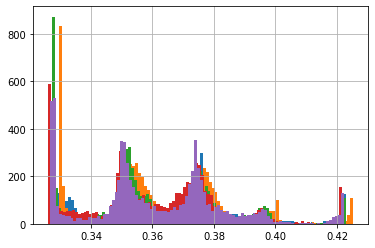

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()